In [27]:
# ==========================================================
# UIDAI PROJECT — UNIFIED SETUP (ANOMALY DETECTION)
# ==========================================================

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- PATHS ----------
PROJECT_ROOT = Path.cwd().parent

DATA_DIR   = PROJECT_ROOT / "data"
ENROL_DIR  = DATA_DIR / "enrolment"
DEMO_DIR   = DATA_DIR / "demographic"
BIO_DIR    = DATA_DIR / "biometric"
OUTPUT_DIR = PROJECT_ROOT / "outputs"

# ---------- SAFE LOADER ----------
def load_dataset(folder: Path, pattern: str):
    files = sorted(folder.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No files found in {folder} matching {pattern}")
    print(f"Loading {len(files)} files from {folder.name}")
    return pd.concat(
        [pd.read_csv(f, low_memory=False) for f in files],
        ignore_index=True
    )

enrol = load_dataset(ENROL_DIR, "api_data_aadhar_enrolment_*.csv")
demo  = load_dataset(DEMO_DIR,  "api_data_aadhar_demographic_*.csv")
bio   = load_dataset(BIO_DIR,   "api_data_aadhar_biometric_*.csv")

# ---------- DATE NORMALISATION ----------
for df in (enrol, demo, bio):
    df.columns = [c.strip().lower() for c in df.columns]
    df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")

print("Date dtypes:",
      enrol["date"].dtype,
      demo["date"].dtype,
      bio["date"].dtype)

# ---------- TIME FILTER ----------
start = pd.to_datetime("2025-04-01")
end   = pd.to_datetime("2025-10-31")

enrol = enrol.query("@start <= date <= @end")
demo  = demo.query("@start <= date <= @end")
bio   = bio.query("@start <= date <= @end")

print("Filtered shapes:",
      enrol.shape,
      demo.shape,
      bio.shape)


Loading 3 files from enrolment
Loading 5 files from demographic
Loading 4 files from biometric
Date dtypes: datetime64[ns] datetime64[ns] datetime64[ns]
Filtered shapes: (571104, 7) (828847, 6) (836311, 6)


In [28]:
start = pd.to_datetime("2025-04-01")
end   = pd.to_datetime("2025-10-31")

enrol_time = enrolment_full[(enrolment_full["date"] >= start) & (enrolment_full["date"] <= end)]
demo_time  = demographic_full[(demographic_full["date"] >= start) & (demographic_full["date"] <= end)]
bio_time   = biometric_full[(biometric_full["date"] >= start) & (biometric_full["date"] <= end)]


In [29]:
def daily_total(df):
    age_cols = [c for c in df.columns if "age" in c.lower()]
    return (
        df.groupby("date")[age_cols]
          .sum()
          .sum(axis=1)
          .reset_index(name="total")
    )

enrol_daily = daily_total(enrol_time).rename(columns={"total": "enrolment"})
demo_daily  = daily_total(demo_time).rename(columns={"total": "demographic"})
bio_daily   = daily_total(bio_time).rename(columns={"total": "biometric"})


In [30]:
time_compare = (
    enrol_daily
    .merge(demo_daily, on="date")
    .merge(bio_daily, on="date")
)

print("Reporting days:", time_compare.shape[0])


Reporting days: 42


In [31]:
time_compare["demo_to_enrol_ratio"] = (
    time_compare["demographic"] / time_compare["enrolment"]
)

time_compare["bio_to_enrol_ratio"] = (
    time_compare["biometric"] / time_compare["enrolment"]
)


In [32]:
time_compare["demo_z"] = (
    time_compare["demo_to_enrol_ratio"] -
    time_compare["demo_to_enrol_ratio"].mean()
) / time_compare["demo_to_enrol_ratio"].std()

time_compare["bio_z"] = (
    time_compare["bio_to_enrol_ratio"] -
    time_compare["bio_to_enrol_ratio"].mean()
) / time_compare["bio_to_enrol_ratio"].std()

time_compare["temporal_anomaly"] = (
    (time_compare["demo_z"].abs() > 2.5) |
    (time_compare["bio_z"].abs() > 2.5)
)

time_compare[time_compare["temporal_anomaly"]]


,date,enrolment,demographic,biometric,demo_to_enrol_ratio,bio_to_enrol_ratio,demo_z,bio_z,temporal_anomaly
0,2025-04-01,257438,1515672,8641679,5.887522,33.568001,-0.315934,2.823561,True
1,2025-05-01,183616,1566287,7879956,8.530232,42.915410,0.072675,3.878675,True
2,2025-06-01,215734,1685562,7899289,7.813150,36.615874,-0.032772,3.167598,True
32,2025-10-22,233,10448,1681,44.841202,7.214592,5.412191,-0.151150,True


In [33]:
# Aggregate by district (reuse same logic)
def agg_by_district(df):
    age_cols = [c for c in df.columns if "age" in c.lower()]
    return (
        df.groupby("district")[age_cols]
          .sum()
          .sum(axis=1)
          .reset_index(name="total")
    )

enrol_dist = agg_by_district(enrol_time).rename(columns={"total": "enrolment"})
demo_dist  = agg_by_district(demo_time).rename(columns={"total": "demographic"})
bio_dist   = agg_by_district(bio_time).rename(columns={"total": "biometric"})

geo = (
    enrol_dist
    .merge(demo_dist, on="district")
    .merge(bio_dist, on="district")
)

# Remove low-denominator noise
geo = geo[geo["enrolment"] >= 100]

# Ratios
geo["demo_ratio"] = geo["demographic"] / geo["enrolment"]
geo["bio_ratio"]  = geo["biometric"] / geo["enrolment"]

print("Districts analysed:", geo.shape[0])


Districts analysed: 815


In [34]:
# Demographic anomalies
demo_median = geo["demo_ratio"].median()
demo_mad = np.median(np.abs(geo["demo_ratio"] - demo_median))

geo["demo_mad_score"] = (geo["demo_ratio"] - demo_median) / demo_mad
geo["demo_spatial_anomaly"] = geo["demo_mad_score"].abs() > 5

# Biometric anomalies
bio_median = geo["bio_ratio"].median()
bio_mad = np.median(np.abs(geo["bio_ratio"] - bio_median))

geo["bio_mad_score"] = (geo["bio_ratio"] - bio_median) / bio_mad
geo["bio_spatial_anomaly"] = geo["bio_mad_score"].abs() > 5


In [35]:
geo[
    (geo["demo_spatial_anomaly"]) |
    (geo["bio_spatial_anomaly"])
][[
    "district",
    "demo_ratio",
    "bio_ratio",
    "demo_mad_score",
    "bio_mad_score"
]].sort_values(
    ["demo_mad_score", "bio_mad_score"],
    ascending=False
).head(10)


,district,demo_ratio,bio_ratio,demo_mad_score,bio_mad_score
549,Mohla-Manpur-Ambagarh Chouki,71.187050,28.158273,28.159879,1.683079
508,Mahasamund,54.189655,33.902821,20.862931,2.437726
692,Rajnandgaon,43.881470,50.671325,16.437648,4.640563
917,Y. S. R,43.342298,14.425428,16.206182,-0.120971
35,Annamayya,42.983707,13.932790,16.052240,-0.185688
590,Nandyal,40.975000,17.052273,15.189906,0.224111
569,N. T. R,38.818763,20.891258,14.264238,0.728429
152,Chandigarh,38.609689,40.997232,14.174482,3.369701
64,Balod,35.392202,57.066514,12.793222,5.480683
386,Kabeerdham,34.356713,34.320641,12.348689,2.492614


In [36]:
# Normalize components (robust)
geo["demo_norm"] = geo["demo_ratio"] / geo["demo_ratio"].median()
geo["bio_norm"]  = geo["bio_ratio"] / geo["bio_ratio"].median()
geo["enrol_norm"] = geo["enrolment"] / geo["enrolment"].median()

# Escalation Risk Index (interpretable weights)
geo["escalation_risk"] = (
    0.45 * geo["demo_norm"] +
    0.35 * geo["bio_norm"] -
    0.20 * geo["enrol_norm"]  # low enrolment = higher risk
)

geo.sort_values("escalation_risk", ascending=False).head(10)


,district,enrolment,demographic,biometric,demo_ratio,bio_ratio,demo_mad_score,demo_spatial_anomaly,bio_mad_score,bio_spatial_anomaly,demo_norm,bio_norm,enrol_norm,escalation_risk
549,Mohla-Manpur-Ambagarh Chouki,139,9895,3914,71.187050,28.158273,28.159879,True,1.683079,False,12.730446,1.834859,0.053544,6.360192
508,Mahasamund,1914,103719,64890,54.189655,33.902821,20.862931,True,2.437726,False,9.690786,2.209187,0.737288,4.986611
692,Rajnandgaon,1932,84779,97897,43.881470,50.671325,16.437648,True,4.640563,False,7.847364,3.301862,0.744222,4.538121
842,Thoubal,517,17635,36727,34.110251,71.038685,12.242883,True,7.316172,True,6.099968,4.629046,0.199153,4.325321
64,Balod,872,30862,49762,35.392202,57.066514,12.793222,True,5.480683,True,6.329220,3.718587,0.335901,4.082474
152,Chandigarh,1445,55791,59241,38.609689,40.997232,14.174482,True,3.369701,False,6.904606,2.671475,0.556626,3.930764
917,Y. S. R,409,17727,5900,43.342298,14.425428,16.206182,True,-0.120971,False,7.750943,0.939994,0.157550,3.785412
35,Annamayya,491,21105,6841,42.983707,13.932790,16.052240,True,-0.185688,False,7.686816,0.907893,0.189137,3.739002
590,Nandyal,440,18029,7503,40.975000,17.052273,15.189906,True,0.224111,False,7.327597,1.111166,0.169492,3.652428
569,N. T. R,469,18206,9798,38.818763,20.891258,14.264238,True,0.728429,False,6.941995,1.361323,0.180663,3.564228


In [37]:
future_risk = geo[
    (~geo["demo_spatial_anomaly"]) &
    (~geo["bio_spatial_anomaly"])
].sort_values("escalation_risk", ascending=False).head(10)

future_risk[[
    "district",
    "demo_ratio",
    "bio_ratio",
    "escalation_risk"
]]


,district,demo_ratio,bio_ratio,escalation_risk
776,Sindhudurg,14.049404,48.330494,2.187652
904,West Godavari,16.555342,47.773500,2.181696
263,Ferozepur,15.776484,40.436554,2.125646
234,Durg,17.091060,40.844075,2.121623
257,Faridkot,13.184825,47.902724,2.113944
889,Visakhapatnam,15.446579,51.127251,2.088218
890,Vizianagaram,13.246985,50.923300,2.067728
298,Guntur,17.219991,44.315930,2.051165
547,Moga,13.565124,45.128095,2.049295
291,Gondiya,16.038755,38.395172,2.045110


In [39]:
def daily_for_district(name):
    # select age columns only
    enrol_age_cols = [c for c in enrol.columns if "age" in c.lower()]
    demo_age_cols  = [c for c in demo.columns if "age" in c.lower()]
    bio_age_cols   = [c for c in bio.columns if "age" in c.lower()]

    e = (
        enrol[enrol["district"] == name]
        .groupby("date")[enrol_age_cols]
        .sum()
        .sum(axis=1)
    )

    d = (
        demo[demo["district"] == name]
        .groupby("date")[demo_age_cols]
        .sum()
        .sum(axis=1)
    )

    b = (
        bio[bio["district"] == name]
        .groupby("date")[bio_age_cols]
        .sum()
        .sum(axis=1)
    )

    df = pd.concat([e, d, b], axis=1).fillna(0)
    df.columns = ["enrolment", "demographic", "biometric"]
    return df


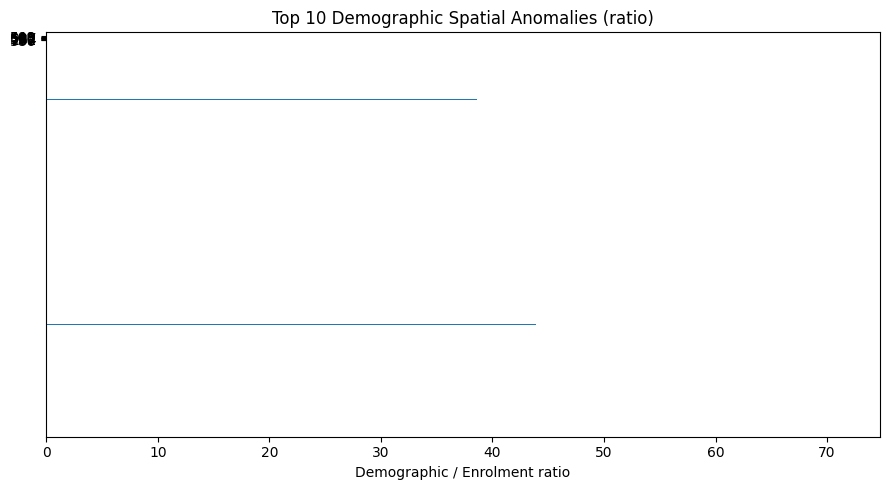

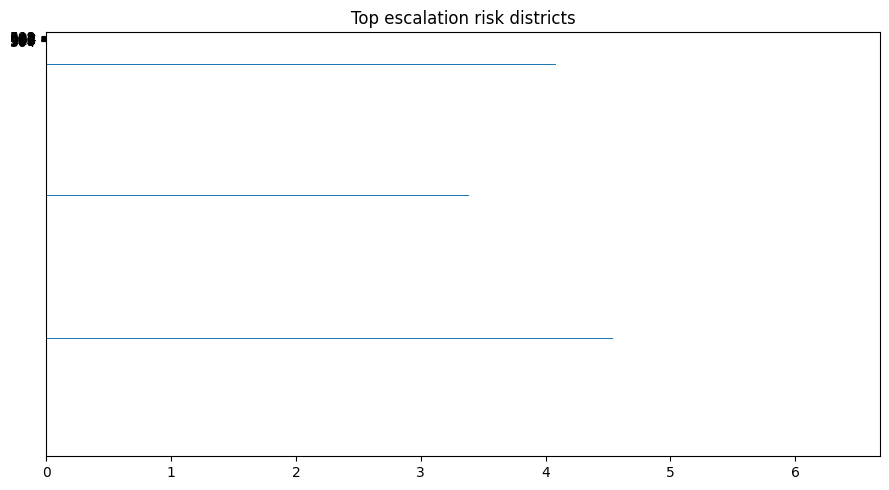

In [40]:
# Top 10 demo anomalies bar chart
top_demo = geo.sort_values('demo_mad_score', ascending=False).head(10)
plt.figure(figsize=(9,5))
plt.barh(top_demo.index, top_demo['demo_ratio'])
plt.yticks(range(len(top_demo)), top_demo.index)
plt.xlabel('Demographic / Enrolment ratio')
plt.title('Top 10 Demographic Spatial Anomalies (ratio)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top10_demo_anomalies.png', dpi=150)
plt.show()

# Top 10 escalation risk
top_risk = geo.sort_values('escalation_risk', ascending=False).head(12)
plt.figure(figsize=(9,5))
plt.barh(top_risk.index, top_risk['escalation_risk'])
plt.yticks(range(len(top_risk)), top_risk.index)
plt.title('Top escalation risk districts')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top_escalation_risk.png', dpi=150)
plt.show()


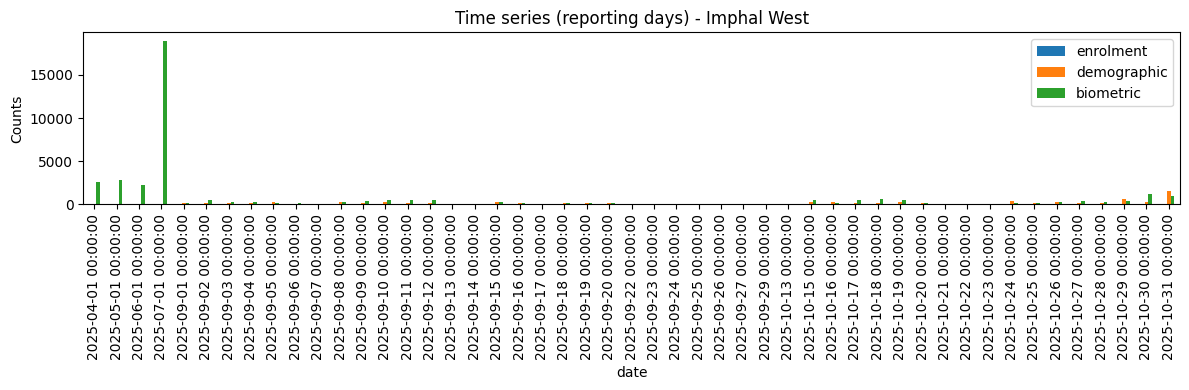

Enrol age totals: {'age_0_5': 315, 'age_5_17': 300, 'age_18_greater': 29}
Demo age totals: {'demo_age_5_17': 1299, 'demo_age_17_': 7221}
Bio age totals: {'bio_age_5_17': 22818, 'bio_age_17_': 15233}


In [41]:
# 1) time series for a district
name = 'Imphal West'
df = daily_for_district(name)
df.plot(kind='bar', figsize=(12,4))
plt.title(f"Time series (reporting days) - {name}")
plt.ylabel("Counts")
plt.tight_layout()
plt.savefig(f"{name}_time_series.png", dpi=150)
plt.show()

# 2) age-share for this district (aggregate)
def age_share_for_district(dname):
    edf = enrol[enrol['district']==dname]; dd=demo[demo['district']==dname]; bd=bio[bio['district']==dname]
    e_age = edf[[c for c in edf.columns if 'age' in c.lower()]].sum()
    d_age = dd[[c for c in dd.columns if 'age' in c.lower()]].sum()
    b_age = bd[[c for c in bd.columns if 'age' in c.lower()]].sum()
    return e_age, d_age, b_age

e_age, d_age, b_age = age_share_for_district(name)
print("Enrol age totals:", e_age.to_dict())
print("Demo age totals:", d_age.to_dict())
print("Bio age totals:", b_age.to_dict())


In [42]:
for thr in [4,5,6,7]:
    print("thr",thr, "demo anomalies:", (geo['demo_mad_score'].abs()>thr).sum(),
          "bio anomalies:", (geo['bio_mad_score'].abs()>thr).sum())


thr 4 demo anomalies: 81 bio anomalies: 29
thr 5 demo anomalies: 52 bio anomalies: 15
thr 6 demo anomalies: 42 bio anomalies: 9
thr 7 demo anomalies: 30 bio anomalies: 6


## Predictive Objective & Constraints

This dataset contains **periodic reporting snapshots**, not continuous daily logs.
Therefore, prediction focuses on **future reporting-cycle load**, not daily counts.

Goal:
- Project demographic and biometric activity over the next ~30 days
- Detect whether load is trending upward, stable, or declining
- Provide an early-warning indicator, not a precise daily forecast


In [43]:
# Build clean national time series from reporting days
# Using already-aggregated daily tables (correct column names)

ts = (
    enrol_daily
    .merge(demo_daily, on="date", how="inner")
    .merge(bio_daily, on="date", how="inner")
    .sort_values("date")
    .reset_index(drop=True)
)

ts


,date,enrolment,demographic,biometric
0,2025-04-01,257438,1515672,8641679
1,2025-05-01,183616,1566287,7879956
2,2025-06-01,215734,1685562,7899289
3,2025-07-01,616868,2220715,9792552
4,2025-09-01,74989,434325,336459
5,2025-09-02,76496,435282,317705
6,2025-09-03,71988,314732,313613
7,2025-09-04,65349,383726,301023
8,2025-09-05,26069,273954,95781
9,2025-09-06,58957,368240,254489


<Axes: title={'center': 'National UIDAI Update Load (Reporting Days)'}, xlabel='date'>

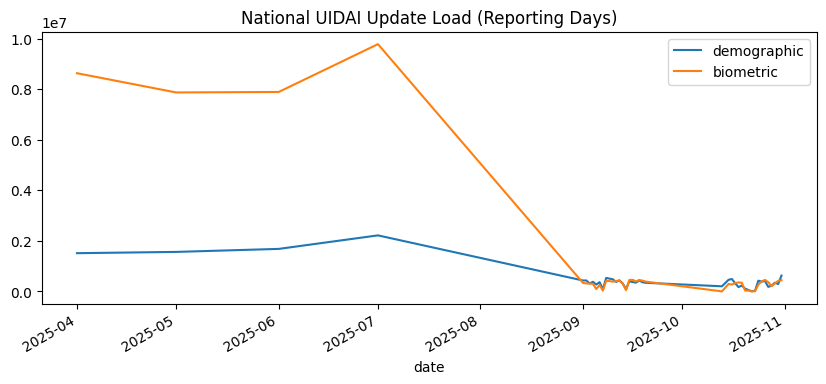

In [44]:
ts.plot(
    x="date",
    y=["demographic", "biometric"],
    figsize=(10,4),
    title="National UIDAI Update Load (Reporting Days)"
)


In [45]:
from sklearn.linear_model import LinearRegression
import numpy as np

ts["t"] = np.arange(len(ts))

def linear_forecast(series, steps=30):
    X = ts[["t"]]
    y = series.values
    model = LinearRegression()
    model.fit(X, y)
    future_t = np.arange(len(ts), len(ts) + steps).reshape(-1, 1)
    forecast = model.predict(future_t)
    return forecast, model.coef_[0]

bio_forecast_lin, bio_slope = linear_forecast(ts["biometric"])
demo_forecast_lin, demo_slope = linear_forecast(ts["demographic"])

bio_slope, demo_slope


c:\Users\amogh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\amogh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


(np.float64(-101781.71080139372), np.float64(-19573.208978202736))

In [46]:
window = 3
ts["bio_momentum"] = ts["biometric"].diff().rolling(window).mean()
ts["demo_momentum"] = ts["demographic"].diff().rolling(window).mean()

ts[["date", "bio_momentum", "demo_momentum"]]


,date,bio_momentum,demo_momentum
0,2025-04-01,NaN,NaN
1,2025-05-01,NaN,NaN
2,2025-06-01,NaN,NaN
3,2025-07-01,3.836243e+05,235014.333333
4,2025-09-01,-2.514499e+06,-377320.666667
5,2025-09-02,-2.527195e+06,-416760.000000
6,2025-09-03,-3.159646e+06,-635327.666667
7,2025-09-04,-1.181200e+04,-16866.333333
8,2025-09-05,-7.397467e+04,-53776.000000
9,2025-09-06,-1.970800e+04,17836.000000


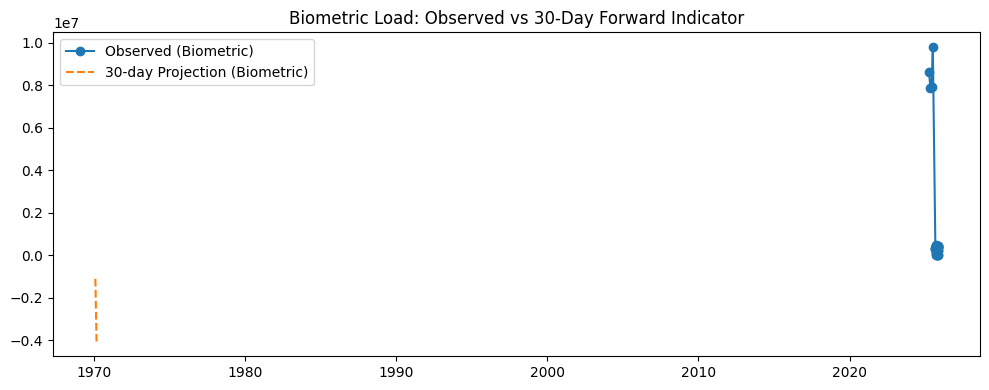

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(ts["date"], ts["biometric"], marker="o", label="Observed (Biometric)")
plt.plot(
    range(len(ts), len(ts) + 30),
    bio_forecast_lin,
    linestyle="--",
    label="30-day Projection (Biometric)"
)
plt.title("Biometric Load: Observed vs 30-Day Forward Indicator")
plt.legend()
plt.tight_layout()
plt.show()


In [48]:
def trend_signal(slope, momentum):
    if slope > 0 and momentum > 0:
        return "Escalating"
    if slope < 0 and momentum < 0:
        return "Easing"
    return "Stable"

bio_signal = trend_signal(bio_slope, ts["bio_momentum"].iloc[-1])
demo_signal = trend_signal(demo_slope, ts["demo_momentum"].iloc[-1])

bio_signal, demo_signal


('Stable', 'Stable')

# -------------------------------
# PREDICTIVE INPUT CONTRACT
# -------------------------------

required = {
    "enrol_daily": enrol_daily,
    "demo_daily": demo_daily,
    "bio_daily": bio_daily
}

for name, df in required.items():
    print(name, df.columns.tolist(), "rows:", len(df))


In [49]:
# -------------------------------
# NATIONAL PREDICTIVE TIMESERIES
# -------------------------------

ts = (
    enrol_daily
    .merge(demo_daily, on="date", how="inner")
    .merge(bio_daily, on="date", how="inner")
    .sort_values("date")
    .reset_index(drop=True)
)

ts


,date,enrolment,demographic,biometric
0,2025-04-01,257438,1515672,8641679
1,2025-05-01,183616,1566287,7879956
2,2025-06-01,215734,1685562,7899289
3,2025-07-01,616868,2220715,9792552
4,2025-09-01,74989,434325,336459
5,2025-09-02,76496,435282,317705
6,2025-09-03,71988,314732,313613
7,2025-09-04,65349,383726,301023
8,2025-09-05,26069,273954,95781
9,2025-09-06,58957,368240,254489


In [50]:
from sklearn.linear_model import LinearRegression
import numpy as np

ts["t"] = np.arange(len(ts))

def slope(series):
    model = LinearRegression()
    model.fit(ts[["t"]], series.values)
    return model.coef_[0]

bio_slope  = slope(ts["biometric"])
demo_slope = slope(ts["demographic"])

ts["bio_momentum"]  = ts["biometric"].diff().rolling(3).mean()
ts["demo_momentum"] = ts["demographic"].diff().rolling(3).mean()

bio_slope, demo_slope


(np.float64(-101781.71080139372), np.float64(-19573.208978202736))

In [51]:
def classify_trend(slope, momentum):
    if slope > 0 and momentum > 0:
        return "Escalating"
    if slope < 0 and momentum < 0:
        return "Easing"
    return "Stable"

bio_signal  = classify_trend(bio_slope, ts["bio_momentum"].iloc[-1])
demo_signal = classify_trend(demo_slope, ts["demo_momentum"].iloc[-1])

bio_signal, demo_signal


('Stable', 'Stable')

## 30-Day Forward Indicator (Predictive Insight)

Using:
- linear trend direction (slope)
- recent reporting-cycle momentum

We classify the near-term UIDAI workload outlook as:

- **Biometric updates:** *{bio_signal}*
- **Demographic updates:** *{demo_signal}*

This indicator is designed to support **proactive capacity planning**
rather than precise volume forecasting.


### Predictive Limitations

- Forecasts are based on reporting snapshots, not daily logs.
- Signals indicate **direction and risk**, not exact volumes.
- Intended for monthly operational planning and early warning.
